# K-Means Clustering of Soccer Player Attributes with SparkML

## Process Data into Spark DataFrame

Note: Player and Player_Attributes data is available at https://www.kaggle.com/hugomathien/soccer

In [2]:
player_file = "data/Player.csv"
attributes_file = "data/Player_Attributes.csv"

In [122]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SQLContext

In [5]:
# Functions for safely converting data types, returning None for invalid values
def toIntSafe(x):
    try:
        return int(x)
    except ValueError:
        return None

def toTimeSafe(x):
    try:
        return datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        return None

def toFloatSafe(x):
    try:
        return float(x)
    except ValueError:
        return None

### Read in player_file and convert to Spark DataFrame

In [24]:
# Define player_df schema (name, dataType, nullable) and csv parser
# Note that data has three different ids, but only player_api_id is kept
playerSchema = StructType([
    StructField("player_api_id", IntegerType(), False),
    StructField("player_name", StringType(), True),
    StructField("birthday", TimestampType(), True),
    StructField("height", FloatType(), True),
    StructField("weight", IntegerType(), True)
    ])

def playerRow(line):
    """Creates DataFrame Row from line of data from player_file"""
    s = line.split(',')
    return Row(
        toIntSafe(s[1]),              # player_api_id
        s[2].strip('"'),              # player name
        toTimeSafe(s[4].strip('"')),  # birthday
        toFloatSafe(s[5]),            # height
        toIntSafe(s[6]))              # weight

# Create RDD, then DataFrame from RDD
player_rdd = sc.textFile(player_file)
player_header = player_rdd.first()
player_rdd = player_rdd.filter(lambda row: row != player_header).persist()
player_df = sqlContext.createDataFrame(player_rdd.map(lambda row: playerRow(row)), playerSchema)

In [25]:
player_df.first()

Row(player_api_id=505942, player_name=u'Aaron Appindangoye', birthday=datetime.datetime(1992, 2, 29, 0, 0), height=182.8800048828125, weight=187)

### Read in attributes_file and convert to Spark DataFrame

In [26]:
# Define attribute score columns, and categories of attributes
attributes = ['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
             'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control',
             'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
             'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
             'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
             'marking', 'standing_tackle', 'sliding_tackle',
             'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

attr_cats = ['movement', 'attacking', 'skill', 'power', 'mentality',
             'defending', 'goalkeeping']

attacking = attributes[:5]
skill = attributes[5:10]
movement = attributes[10:15]
power = attributes[15:20]
mentality = attributes[20:25]
defending = attributes[25:28]
goalkeeping = attributes[28:]


# Define attributes_df schema (name, dataType, nullable) and csv parser
attributesSchema = StructType(
   [StructField("player_api_id", IntegerType(), False),
    StructField("date", TimestampType(), True),
    StructField("overall_rating", IntegerType(), True),
    StructField("potential", IntegerType(), True),
    StructField("preferred_foot", StringType(), True),
    StructField("attacking_work_rate", StringType(), True),
    StructField("defensive_work_rate", StringType(), True)] + 
   [StructField(attr, IntegerType(), True) for attr in attributes])

def attributesRow(line):
    """Creates DataFrame Row from line of data from attributes_file"""
    s = line.split(',')
    return Row(
        toIntSafe(s[2]),              # player_api_id
        toTimeSafe(s[3].strip('"')),  # date
        toIntSafe(s[4]),              # overall rating
        toIntSafe(s[5]),              # potential
        s[6],                         # preferred foot
        s[7],                         # attacking_work_rate
        s[8],                         # defensive_work_rate
        *[toIntSafe(field) for field in s[9:]]) # attributes

# Create RDD, then DataFrame from RDD
attributes_rdd = sc.textFile(attributes_file)
attributes_header = attributes_rdd.first()
attributes_rdd = attributes_rdd.filter(lambda row: row != attributes_header).persist()
attributes_df = sqlContext.createDataFrame(attributes_rdd.map(lambda row: attributesRow(row)), attributesSchema)

In [27]:
attributes_df.first()

Row(player_api_id=505942, date=datetime.datetime(2016, 2, 18, 0, 0), overall_rating=67, potential=71, preferred_foot=u'right', attacking_work_rate=u'medium', defensive_work_rate=u'medium', crossing=49, finishing=44, heading_accuracy=71, short_passing=61, volleys=44, dribbling=51, curve=45, free_kick_accuracy=39, long_passing=64, ball_control=49, acceleration=60, sprint_speed=64, agility=59, reactions=47, balance=65, shot_power=55, jumping=58, stamina=54, strength=76, long_shots=35, aggression=71, interceptions=70, positioning=45, vision=54, penalties=48, marking=65, standing_tackle=69, sliding_tackle=69, gk_diving=6, gk_handling=11, gk_kicking=10, gk_positioning=8, gk_reflexes=8)

### Merge Player and Attributes DataFrames on player_api_id

In [28]:
df = player_df.join(attributes_df, ['player_api_id'], 'left')

# Calculate player age based on birthday and date of attribute scores
df = df.withColumn('age', datediff('date', 'birthday') / 365.25)

In [29]:
df.first()

Row(player_api_id=11317, player_name=u'Florent Ghisolfi', birthday=datetime.datetime(1985, 2, 28, 0, 0), height=175.25999450683594, weight=154, date=datetime.datetime(2014, 3, 21, 0, 0), overall_rating=64, potential=65, preferred_foot=u'right', attacking_work_rate=u'medium', defensive_work_rate=u'medium', crossing=44, finishing=40, heading_accuracy=59, short_passing=67, volleys=40, dribbling=61, curve=41, free_kick_accuracy=49, long_passing=65, ball_control=63, acceleration=58, sprint_speed=61, agility=60, reactions=69, balance=74, shot_power=53, jumping=62, stamina=71, strength=64, long_shots=57, aggression=76, interceptions=61, positioning=55, vision=63, penalties=44, marking=55, standing_tackle=71, sliding_tackle=61, gk_diving=7, gk_handling=10, gk_kicking=15, gk_positioning=5, gk_reflexes=9, age=29.05681040383299)

## Feature Extraction of Attribute Category Scores

### Create DataFrame of single row per player

In [36]:
# Register temporary table for easy querying with Spark SQL
df.registerTempTable('players')

# Select unique player rows as most recent data where no attributes are null
query = """
SELECT *
    FROM players
    INNER JOIN 
    (
        SELECT max(date) as latest_date, player_api_id as id2
        FROM players
        WHERE {}
        GROUP BY player_api_id
    ) as rhs
    ON date = latest_date AND player_api_id = id2
    WHERE overall_rating IS NOT NULL
    """.format(" IS NOT NULL AND ".join(attributes) + " IS NOT NULL")

uniq_playersDF = sqlContext.sql(query)

### Calculate total attribute and category averages, and standardize category scores by dividing by overall average

In [37]:
uniq_playersDF.registerTempTable('players2')
query = """
SELECT *, 
    movement_avg_score/tot_avg_score as movement_std_score, 
    attacking_avg_score/tot_avg_score as attacking_std_score, 
    skill_avg_score/tot_avg_score as skill_std_score, 
    power_avg_score/tot_avg_score as power_std_score, 
    mentality_avg_score/tot_avg_score as mentality_std_score, 
    defending_avg_score/tot_avg_score as defending_std_score, 
    goalkeeping_avg_score/tot_avg_score as goalkeeping_std_score 
        
FROM (
    SELECT *, ({})/{} as tot_avg_score
    FROM (SELECT  *, (({})/{}) as movement_avg_score, 
                     (({})/{}) as attacking_avg_score, 
                     (({})/{}) as skill_avg_score, 
                     (({})/{}) as power_avg_score, 
                     (({})/{}) as mentality_avg_score, 
                     (({})/{}) as defending_avg_score, 
                     (({})/{}) as goalkeeping_avg_score
          FROM players2) as category_scores
     ) as total_averages
""".format("_avg_score+".join(attr_cats) + "_avg_score", len(attr_cats),
                      "+".join(movement), len(movement),
                      "+".join(attacking), len(attacking),
                      "+".join(skill), len(skill),
                      "+".join(power), len(power),
                      "+".join(mentality), len(mentality),
                      "+".join(defending), len(defending),
                      "+".join(goalkeeping), len(goalkeeping)
                      )
std_scoreDF = sqlContext.sql(query)

In [48]:
std_scoreDF.select(['player_name'] + std_scoreDF.columns[-7:]).first()

Row(player_name=u'Matej Krajcik', movement_std_score=1.1815944881889764, attacking_std_score=0.9680118110236221, skill_std_score=1.1058070866141734, power_std_score=1.1919291338582678, mentality_std_score=1.1540354330708662, defending_std_score=1.2573818897637796, goalkeeping_std_score=0.14124015748031496)

## KMeans Clustering

In [125]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
# Transform features (attribute category scores) to DataFrame with 'features' vector
transformer = VectorAssembler(outputCol = 'features', 
                              inputCols = std_scoreDF.columns[-7:])
points = transformer.transform(std_scoreDF).select('features').cache()

In [51]:
# Find appropriate number of clusters, k, by comparing mean 
# within-set sum of squared errors (WSSSE) for various values of k
wssse_list = [0 for x in range(0, 20)]
for k in range(3, 20):
    kmeans = KMeans(k = k)
    model = kmeans.fit(points)
    avg_wssse = model.computeCost(points) / k
    wssse_list[k] = avg_wssse

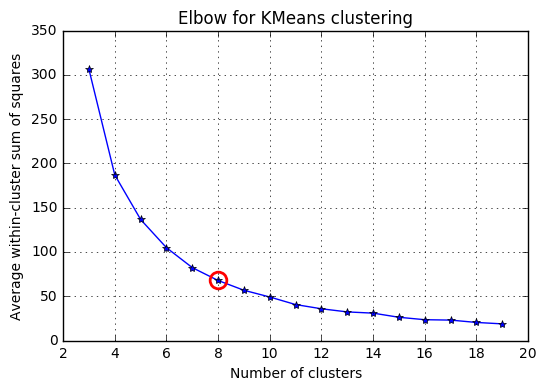

In [52]:
# Plot mean WSSSE, looking for "elbow" indicating diminishing returns
K = range(3, 20)
avg_wssse = wssse_list[3:]
elbow_ix = 5 # elbow point for curve, k = 8 (not a clear elbow point; 6-9 would be reasonable)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avg_wssse, 'b*-')
ax.plot(K[elbow_ix], avg_wssse[elbow_ix], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

In [196]:
# Final clustering with k = 8
k = 8
kmeans = KMeans(k = k)
km_model = kmeans.fit(points)
centers = sorted([(i, km_model.clusterCenters()[i]) for i in range(8)], key = lambda x : x[1][1])
# sorted by attacking strength, preserving prediction number

## Visualization of Clusters using PCA

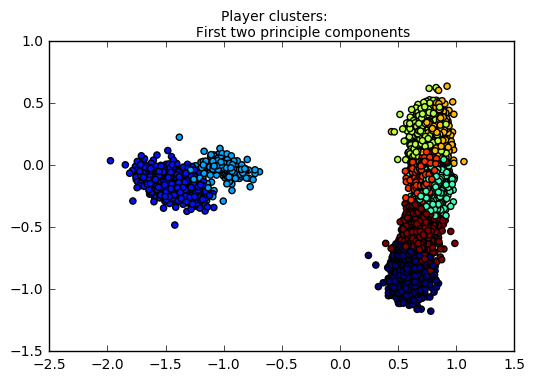

In [188]:
from pyspark.ml.feature import PCA

player_clusters_DF = km_model.transform(points).select("prediction")
player_clustersRDD = player_clusters_DF.rdd

pca = PCA(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(points)
transformed = pca_model.transform(points)

x = [row[0][0] for row in transformed.select('pca').rdd.collect()]
y = [row[0][1] for row in transformed.select('pca').rdd.collect()]

fig = plt.figure()
plt.scatter(x, y, c = player_clustersRDD.collect())
fig.suptitle("""Player clusters:
             First two principle components""")

### Clusters are split into two broader groups: goalkeeper types (n = 2) and defender/attacker types (n = 6)

## Radar Plots of Archetypes

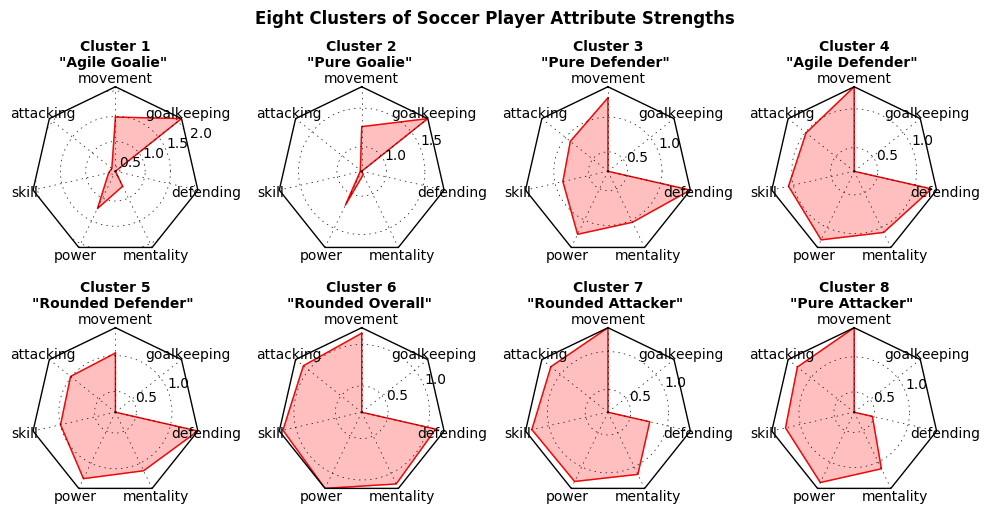

In [198]:
#radar_chart.py from matplotlib api example code, at
#http://matplotlib.org/1.2.1/examples/api/radar_chart.html
from radar_chart import radar_factory
# Set number of attributes N and create radar chart for N axes
N = 7
theta = radar_factory(N, frame='polygon')

nicknames = ['Agile Goalie', 'Pure Goalie',  'Pure Defender', 'Agile Defender', 'Rounded Defender', 'Rounded Overall',
            'Rounded Attacker', 'Pure Attacker']
data = [("""Cluster {}\n"{}" """.format(x + 1, nicknames[x]), list(centers[x][1])) for x in range(k)]
spoke_labels = attr_cats

fig, axes = plt.subplots(figsize=(10, 5), nrows=2, ncols=4,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
# Plot the 8 clusters on separate axes
for ax, (title, case_data) in zip(axes.flatten(), data):
    ax.set_rgrids([0.1, 0.5, 1.0, 1.5, 2.0])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.15),
                 horizontalalignment='center', verticalalignment='center')
    ax.plot(theta, case_data, color='r')
    ax.fill(theta, case_data, facecolor='r', alpha=0.25)
    ax.set_varlabels(spoke_labels)


fig.text(0.5, 1, 'Eight Clusters of Soccer Player Attribute Strengths',
         horizontalalignment='center', color='black', weight='bold',
         size='large')
fig.tight_layout()
plt.show()
plt.close()

## Cluster/Archetype Characteristics and Top Players

In [184]:
## Assign clusters to playerIds
from pyspark.sql.functions import monotonically_increasing_id
player_clusters_DF = player_clusters_DF.withColumnRenamed('prediction', 'cluster').withColumn('cluster_row_id', monotonically_increasing_id())
# add row ids to main DF
resultsDF = std_scoreDF.withColumn('row_id', monotonically_increasing_id())
# join main df with clusters on row ids
resultsDF = resultsDF.join(player_clusters_DF, resultsDF.row_id == player_clusters_DF.cluster_row_id, 'inner')

### Group characteristics

In [206]:
cluster_names = [name for (cluster, name) in sorted(zip([c[0] for c in centers],nicknames))]
resultsDF.registerTempTable('final_results')
query = """
SELECT cluster + 1 as cluster, (CASE cluster {} END) AS nickname, 
    round(avg(overall_rating), 2) as overall, 
    min(overall_rating) as min, 
    max(overall_rating) as max, 
    round(avg(potential),2) as potential, 
    round(avg(age),2) as age, 
    round(avg(height),2) as height, 
    round(avg(weight),2) as weight,
    round(avg(weight) * .45 / (avg(height)/100 * avg(height)/100), 2) as bmi
FROM final_results
GROUP BY 1, 2
ORDER BY 1
""".format(" ".join(["when {} then '{}'".format(x, cluster_names[x]) for x in range(len(cluster_names))]))
sqlContext.sql(query).show()

+-------+----------------+-------+---+---+---------+-----+------+------+-----+
|cluster|        nickname|overall|min|max|potential|  age|height|weight|  bmi|
+-------+----------------+-------+---+---+---------+-----+------+------+-----+
|      1|   Pure Attacker|  68.63| 50| 94|    72.05|26.81|180.34|165.44|22.89|
|      2|    Agile Goalie|  69.09| 51| 90|    71.28|29.66|188.78|184.48|23.29|
|      3|     Pure Goalie|  63.71| 48| 81|    65.89|30.64|188.69|183.83|23.23|
|      4| Rounded Overall|  69.15| 49| 87|    71.07|29.29|181.14|166.86|22.88|
|      5|   Pure Defender|  66.79| 47| 86|    70.74|26.28|185.01|173.01|22.75|
|      6|Rounded Defender|  70.04| 50| 88|    71.27|30.48|187.17|180.01|23.12|
|      7|  Agile Defender|  66.27| 47| 87|    70.02|26.51|179.26|162.47|22.75|
|      8|Rounded Attacker|  68.21| 47| 90|    71.28|27.58|178.84|161.97|22.79|
+-------+----------------+-------+---+---+---------+-----+------+------+-----+



### Classification of Top Tier Players

In [207]:
query = """
SELECT player_name as player, overall_rating as rating,
       cluster + 1 as cluster,
       (CASE cluster {} END) AS nickname
FROM final_results
WHERE overall_rating > 86
ORDER BY 2 DESC
""".format(" ".join(["when {} then '{}'".format(x, cluster_names[x]) for x in range(len(cluster_names))]))
sqlContext.sql(query).show(100)

+------------------+------+-------+----------------+
|            player|rating|cluster|        nickname|
+------------------+------+-------+----------------+
|      Lionel Messi|    94|      1|   Pure Attacker|
| Cristiano Ronaldo|    93|      1|   Pure Attacker|
|      Manuel Neuer|    90|      2|    Agile Goalie|
|       Luis Suarez|    90|      8|Rounded Attacker|
|            Neymar|    90|      1|   Pure Attacker|
|      Arjen Robben|    89|      1|   Pure Attacker|
|Zlatan Ibrahimovic|    89|      1|   Pure Attacker|
|       Eden Hazard|    88|      1|   Pure Attacker|
|       Mesut Oezil|    88|      1|   Pure Attacker|
|Robert Lewandowski|    88|      1|   Pure Attacker|
|    Andres Iniesta|    88|      8|Rounded Attacker|
|      Thiago Silva|    88|      6|Rounded Defender|
|     Sergio Aguero|    88|      1|   Pure Attacker|
|       Gareth Bale|    87|      8|Rounded Attacker|
|       Luka Modric|    87|      4| Rounded Overall|
|      Philipp Lahm|    87|      7|  Agile Def

### Top-rated Player(s) in each Cluster

In [208]:
query = """
SELECT a.cluster + 1 as cluster, (CASE a.cluster {} END) AS nickname,
    a.player_name as top_player, a.overall_rating as rating
FROM final_results a
LEFT OUTER JOIN final_results b
    ON a.cluster = b.cluster AND a.overall_rating < b.overall_rating
WHERE b.cluster IS NULL
ORDER BY 1, 4 DESC
""".format(" ".join(["when {} then '{}'".format(x, cluster_names[x]) for x in range(len(cluster_names))]))

sqlContext.sql(query).show()

+-------+----------------+-----------------+------+
|cluster|        nickname|       top_player|rating|
+-------+----------------+-----------------+------+
|      1|   Pure Attacker|     Lionel Messi|    94|
|      2|    Agile Goalie|     Manuel Neuer|    90|
|      3|     Pure Goalie| Mickael Landreau|    81|
|      4| Rounded Overall|      Luka Modric|    87|
|      4| Rounded Overall|       Toni Kroos|    87|
|      5|   Pure Defender|Giorgio Chiellini|    86|
|      6|Rounded Defender|     Thiago Silva|    88|
|      7|  Agile Defender|     Philipp Lahm|    87|
|      8|Rounded Attacker|      Luis Suarez|    90|
+-------+----------------+-----------------+------+

